## Import necessary libraries

In [121]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats

## Define start and end date of the analysis

In [4]:
#Substract 1 from today's date to get yesterday's date
end=date.today()-timedelta(days=1)
#Go back in time by 3 years
start=end-relativedelta(years=3)
print("-"*25)
print("Analysis period")
print("Start date:", start)
print("End date:", end)
print("-"*25)

-------------------------
Analysis period
Start date: 2022-10-26
End date: 2025-10-26
-------------------------


## Create a dataframe of CAC40 companies and ticker_name

In [6]:
companies = np.array([
    "Accor", "Air Liquide", "Airbus", "ArcelorMittal", "Axa", "BNP Paribas", "Bouygues", 
    "Bureau Veritas", "Capgemini", "Carrefour", "Crédit Agricole", "Danone", "Dassault Systèmes", 
    "Edenred", "Engie", "EssilorLuxottica", "Eurofins Scientific", "Hermès", "Kering", "L'Oréal", 
    "Legrand", "LVMH", "Michelin", "Orange", "Pernod Ricard", "Publicis", "Renault", "Safran", 
    "Saint-Gobain", "Sanofi", "Schneider Electric", "Société Générale", "Stellantis", 
    "STMicroelectronics", "Teleperformance", "Thales", "TotalEnergies", "Unibail-Rodamco-Westfield", 
    "Veolia", "Vinci", "CAC 40 Index"
])

sectors=np.array([
    "Consumer Services", "Basic Materials", "Industrials", "Basic Materials", "Financial Services", 
    "Financial Services", "Industrials", "Inspection and certification", "Technology", 
    "Consumer Defensive", "Financial Services", "Consumer Defensive", "Technology", "Industrials", 
    "Utilities", "Healthcare", "Healthcare", "Consumer Cyclical", "Consumer Cyclical", 
    "Consumer Defensive", "Industrials", "Consumer Cyclical", "Industrials", "Communication Services", 
    "Consumer Defensive", "Communication Services", "Consumer Cyclical", "Industrials", 
    "Industrials", "Healthcare", "Industrials", "Financial Services", "Consumer Cyclical", 
    "Technology", "Communication Services", "Industrials", "Energy", "Real Estate", "Industrials", 
    "Industrials", "CAC 40 Index"
])

tickers=np.array([
    "AC.PA", "AI.PA", "AIR.PA", "MT.AS", "CS.PA", "BNP.PA", "EN.PA", "BVI.PA", "CAP.PA", "CA.PA", 
    "ACA.PA", "BN.PA", "DSY.PA", "EDEN.PA", "ENGI.PA", "EL.PA", "ERF.PA", "RMS.PA", "KER.PA", "OR.PA", 
    "LR.PA", "MC.PA", "ML.PA", "ORA.PA", "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", 
    "SU.PA", "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA", "URW.PA", "VIE.PA", "DG.PA", 
    "^FCHI"
])

table_cac_40=pd.DataFrame({
    "Companies": companies,
    "Sector": sectors,
    "Ticker": tickers})

#Size of dataframe
print(f"Size of dataframe: {table_cac_40.shape}\n")
#Display table
table_cac_40.head()

Size of dataframe: (41, 3)



,Companies,Sector,Ticker
0,Accor,Consumer Services,AC.PA
1,Air Liquide,Basic Materials,AI.PA
2,Airbus,Industrials,AIR.PA
3,ArcelorMittal,Basic Materials,MT.AS
4,Axa,Financial Services,CS.PA


In [7]:
#Number of rows= Number of iterations
nb_iter=table_cac_40.shape[0]
print(f"Table CAC 40 contains: {nb_iter}")

Table CAC 40 contains: 41


In [8]:
#Divident payout are decided in advance, before any event take place. auto_adjust is therefore set to True (by default) to rid the analysis of dividend noise.
def get_data(ticker_name, start, end):
    stock=yf.download(ticker_name, start, end, auto_adjust=True, progress=False).drop(columns=['Open','High','Low'])
    #Remove MultiIndex if it exists
    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns=stock.columns.droplevel(1)
    #Remove the column index name
    stock.columns.name=None
    #Add ticker_name
    stock["Ticker"]=ticker_name
    #Reorder columns
    stock=stock[["Ticker", "Close", "Volume"]]
    #Rename Close to adjusted close
    stock.rename(columns={"Close": "Adjusted_Close"}, inplace=True)
    return stock

In [9]:
donnees=get_data("^FCHI", start, end)
donnees.head()

,Ticker,Adjusted_Close,Volume
Date,,,
2022-10-26,^FCHI,6276.310059,68833800
2022-10-27,^FCHI,6244.029785,85178900
2022-10-28,^FCHI,6273.049805,72520200
2022-10-31,^FCHI,6266.770020,66506100
2022-11-01,^FCHI,6328.250000,60553400


## Create DataFrame with all indexes on CAC40 including CAC40

In [11]:
def create_df_analysis(nb_loop=nb_iter):
    tbl_final=[]
    for i in range(nb_loop):
        print(f"Downloading {i+1}/{nb_loop}: {table_cac_40.iloc[i, 0]}")
        tbl1=get_data(table_cac_40.iloc[i, 2], start, end)
        tbl1["Company"]=table_cac_40.iloc[i, 0]
        tbl1["Sector"]=table_cac_40.iloc[i, 1]
        if i!=0:
            tbl_final=pd.concat([tbl_final, tbl1], ignore_index=False)
        else:
            tbl_final=tbl1
    return tbl_final[["Ticker", "Company", "Sector", "Adjusted_Close", "Volume"]]

In [12]:
tbl_analysis=create_df_analysis()
tbl_analysis.head()

,Ticker,Company,Sector,Adjusted_Close,Volume
Date,,,,,
2022-10-26,AC.PA,Accor,Consumer Services,21.443293,958034
2022-10-27,AC.PA,Accor,Consumer Services,21.799767,1088243
2022-10-28,AC.PA,Accor,Consumer Services,21.872890,697391
2022-10-31,AC.PA,Accor,Consumer Services,22.156240,646187
2022-11-01,AC.PA,Accor,Consumer Services,22.110540,774863


## Data Exploration

### Calculate daily returns for each stock

In [15]:
#Sort dataframe by Ticker and Date
tbl_analysis=tbl_analysis.sort_values(["Ticker", "Date"])
#Calculate daily returns (New_Value-Old_value)/Old_value
tbl_analysis["Daily_returns"]=tbl_analysis.groupby("Ticker")["Adjusted_Close"].pct_change()*100
#Overview
tbl_analysis.head()

,Ticker,Company,Sector,Adjusted_Close,Volume,Daily_returns
Date,,,,,,
2022-10-26,AC.PA,Accor,Consumer Services,21.443293,958034,NaN
2022-10-27,AC.PA,Accor,Consumer Services,21.799767,1088243,1.662403
2022-10-28,AC.PA,Accor,Consumer Services,21.872890,697391,0.335434
2022-10-31,AC.PA,Accor,Consumer Services,22.156240,646187,1.295439
2022-11-01,AC.PA,Accor,Consumer Services,22.110540,774863,-0.206263


### Calculate volatility for each stock

In [17]:
tbl_analysis["Volatility_30d"]=tbl_analysis.groupby("Ticker")["Daily_returns"].transform(
    lambda x:x.rolling(window=30).std()
)
tbl_analysis.head()

,Ticker,Company,Sector,Adjusted_Close,Volume,Daily_returns,Volatility_30d
Date,,,,,,,
2022-10-26,AC.PA,Accor,Consumer Services,21.443293,958034,NaN,NaN
2022-10-27,AC.PA,Accor,Consumer Services,21.799767,1088243,1.662403,NaN
2022-10-28,AC.PA,Accor,Consumer Services,21.872890,697391,0.335434,NaN
2022-10-31,AC.PA,Accor,Consumer Services,22.156240,646187,1.295439,NaN
2022-11-01,AC.PA,Accor,Consumer Services,22.110540,774863,-0.206263,NaN


### Data Integrity Checks

In [19]:
def data_integrity_checks(tbl):
    #Define colours
    red="\033[91m"
    green="\033[92m"
    reset="\033[0m"

    print("-"*40)
    print("Data Integrity Checks")
    print("-"*40)
    
    #Number of distinct ticker
    nb_rows=tbl["Ticker"].nunique()
    #Daily Returns
    if tbl["Daily_returns"].isnull().sum()==nb_rows:
        print(f"{green}Nb NaN: {nb_rows} - Daily returns OK{reset}")
    else:
        print(f"{red}Daily returns integrity KO{reset}")
        
    #30 days volatility
    if tbl["Volatility_30d"].isnull().sum()==nb_rows*30:
        print(f"{green}Nb NaN: {nb_rows*30} - 30 days Volatility OK{reset}")
    else:
        print(f"{red}30 days Volatility KO{reset}")    

    print("-"*40)

In [20]:
data_integrity_checks(tbl_analysis)

----------------------------------------
Data Integrity Checks
----------------------------------------
Nb NaN: 41 - Daily returns OK
Nb NaN: 1230 - 30 days Volatility OK
----------------------------------------


In [21]:
# Defining key political events
political_events={
    #"2022-06-19": "Legislative Elections - Macron Loses Majority",
    "2023-04-15": "Pension Reform",
    "2024-01-09": "Appointment of Gabriel Attal",
    "2024-07-16": "Resignation of Gabriel Attal",
    "2024-09-21": "Appointment of Michel Barnier",
    "2024-12-13": "Resignation of Michel Barnier",
    "2024-12-13": "Appointment of François Bayrou",
    "2025-09-09": "Resignation of François Bayrou", 
    "2025-10-06": "Resignation - Sebastien Lecornu",
    "2025-10-10": "Re-appointement of Sebastien Lecornu",
    "2025-10-14": "Suspension of pension reform",
    #2025-10-22": "Macron announces - 'décalage et non suspension de la réforme des retraites'"
}

#Convert to datetime
event_dates={
    pd.to_datetime(date): label for date, label in political_events.items()
}

## Event Analysis

In [23]:
event_dates

{Timestamp('2023-04-15 00:00:00'): 'Pension Reform',
 Timestamp('2024-01-09 00:00:00'): 'Appointment of Gabriel Attal',
 Timestamp('2024-07-16 00:00:00'): 'Resignation of Gabriel Attal',
 Timestamp('2024-09-21 00:00:00'): 'Appointment of Michel Barnier',
 Timestamp('2024-12-13 00:00:00'): 'Appointment of François Bayrou',
 Timestamp('2025-09-09 00:00:00'): 'Resignation of François Bayrou',
 Timestamp('2025-10-06 00:00:00'): 'Resignation - Sebastien Lecornu',
 Timestamp('2025-10-10 00:00:00'): 'Re-appointement of Sebastien Lecornu',
 Timestamp('2025-10-14 00:00:00'): 'Suspension of pension reform'}

In [24]:
def plot_cac40_events(tbl, save_path="cac40_political_events.png"):
    #Filters data
    cac_data=tbl[tbl["Ticker"]=="^FCHI"].copy()
    #Sort data by date
    cac_data.sort_index()
    #Create canvas
    fig, (ax1, ax2)=plt.subplots(2, 1, figsize=(16, 10), 
                                gridspec_kw={"height_ratios": [3, 1]})
    #Title of chart
    fig.suptitle("CAC40 Index Response to French Political Events (2022-2025)", 
             fontsize=16, fontweight="bold", y=0.995)
    #Top Chart
    ax1.plot(cac_data.index, cac_data["Adjusted_Close"], linewidth=2, color="#0051A5", label="CAC40 Index")
    #Adding Event markers
    for event_date, label in event_dates.items():
        if event_date in cac_data.index:
            price=cac_data.loc[event_date, "Adjusted_Close"]
            #Draw dotted line
            ax1.axvline(x=event_date, color="red", linestyle="--", alpha=0.5, linewidth=1.5)
            #Add a triangular marker at event
            ax1.scatter(event_date, price, color="red", s=100, zorder=5, marker="v")
            #Calculates where to put label (puts label above for even events and below for odd ones)
            if list(event_dates.keys()).index(event_date)%2==0:
                y_offset=200
            else:
                y_offset=-200
            #Annotate diagram (Text in yellow, and red lined arrow pointing to the event)
            ax1.annotate(label, xy=(event_date, price), 
                         xytext=(0, y_offset),
                         textcoords='offset points',
                         fontsize=8,
                         ha='center',
                         bbox=dict(boxstyle='round,pad=0.5', 
                                   facecolor='yellow', alpha=0.7),
                         arrowprops=dict(arrowstyle='->',
                                         connectionstyle='arc3,rad=0',
                                         color='red', lw=1.5))
    #Chart Formatting
    #Add labels to axes
    ax1.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax1.set_ylabel("CAC40 Index Level", fontsize=12, fontweight="bold")
    #Add legend
    ax1.legend(loc="upper left", fontsize=10)
    #Add dotted grid
    ax1.grid(True, alpha=0.3, linestyle=":")
    #Format dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    #Set date label each 3 months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #Rotate date labels 45degrees so that they do not overlap
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    #Daily returns
    ax2.bar(cac_data.index, cac_data["Daily_returns"], color=["green" if x > 0 
                                                              else "red" 
                                                              for x in cac_data["Daily_returns"]],
            alpha=0.6, width=1)
    #Add event markers
    for event_date in event_dates.keys():
        if event_date in cac_data.index:
            ax2.axvline(x=event_date, color="red", linestyle="--", alpha=0.5, linewidth=1.5)
    #Add a black line at x=0
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.8)
    #Add axes labels
    ax2.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Daily Return (%)", fontsize=12, fontweight="bold")
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.8)
    #Add dotted grid
    ax2.grid(True, alpha=0.3, linestyle=":")
    #Format dates
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    #Set date label each 3 months
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #Rotate date labels 45degrees so that they do not overlap                                                   
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    #Save chart
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Chart saved to: {save_path}")
    plt.show()

Chart saved to: cac40_political_events.png


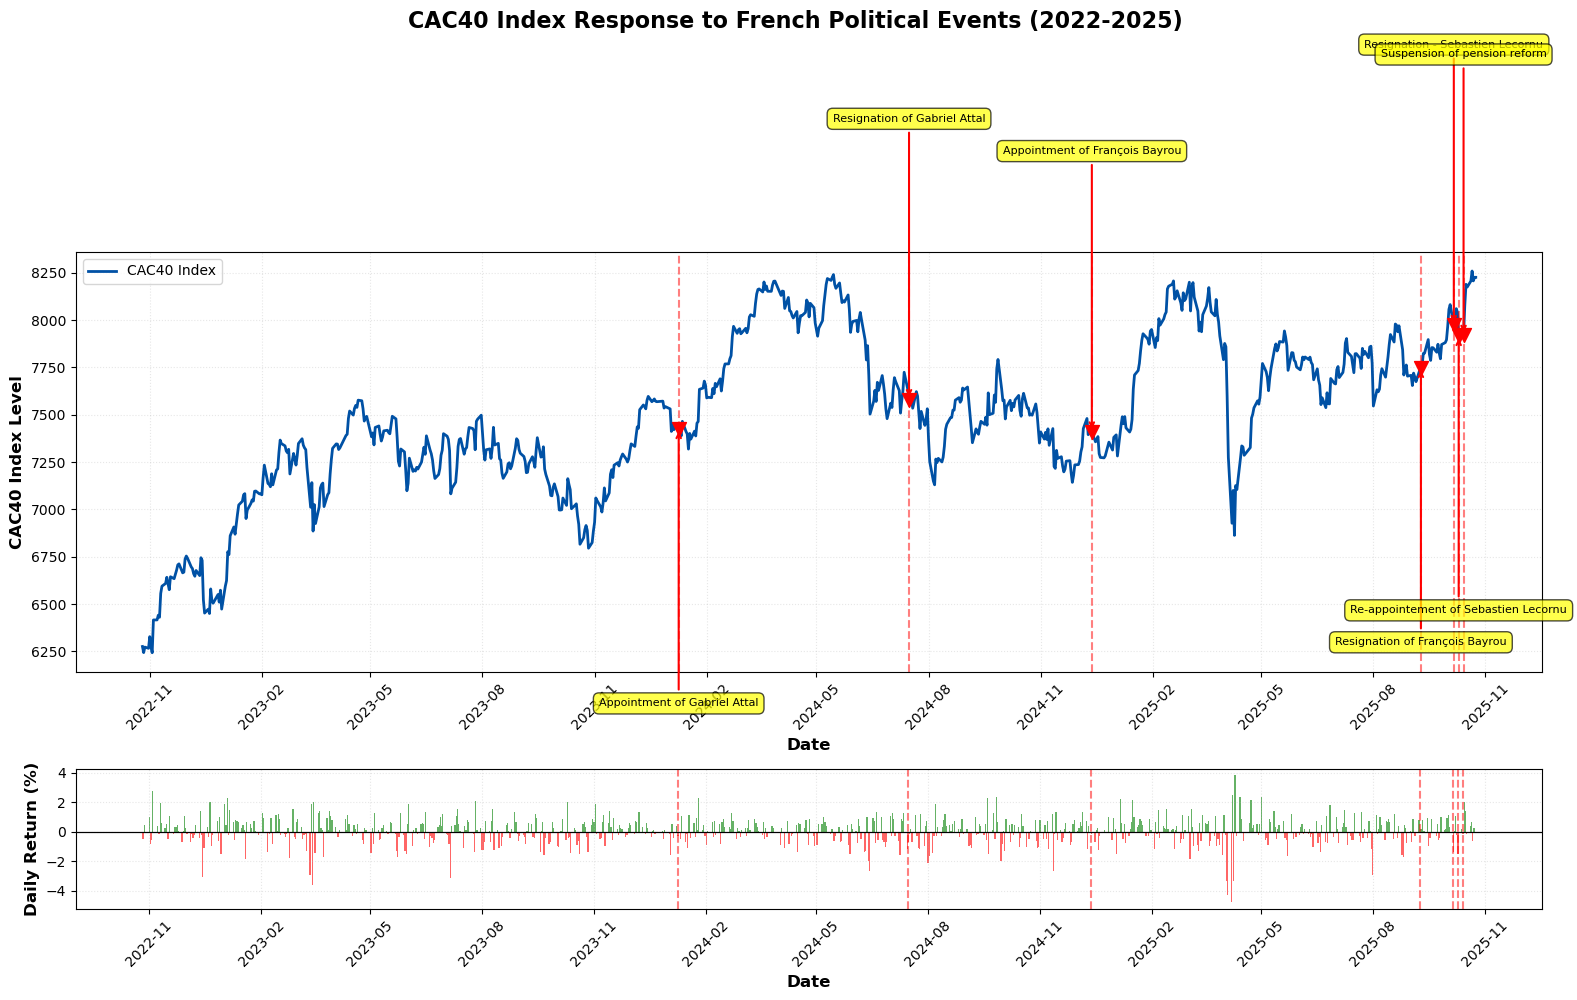

In [25]:
plot_cac40_events(tbl_analysis)

# Impact Analysis

In [108]:
def format_tbl(tbl, highlight_column=None):    
    #Add hover styling
    cell_hover={
        'selector': 'td:hover', #Hover each small cell in the table
        'props': [('background-color', '#ffffb3')] #colour="light yellow"
        }
    index_names={
        'selector': 'th.row_heading',
        'props': 'background-color: #000066; color: white; text-align: left'
    }
    #Center align Mean row index
    mean_row_index={
        'selector': 'th.row_heading.level0.row' + str(len(tbl)-1) if "Mean" in tbl.index else 'th.no-match',
        'props': 'background-color: #e6f2ff; color:black; text-align: center'
    }
    #Highlight the last row ("Mean" row)
    mean_row_style={
        'selector': 'tr:last-child',
        'props': [('background-color', '#e6f2ff'),  # light blue
                  ('font-weight', 'bold') ]
    }
    #Format header
    headers={
        'selector': 'th:not(.index_name)',
        'props': 'background-color: #000066; color: white; text-align: center'
    }
    multi_line_headers={
        'Event Day Return': 'Event Day Return',
        '5-Day Cumulative Return': '5-Day Cumulative Return',
        'Volatility Before (30 days)': 'Volatility Before<br>(30 days)',
        'Volatility After (30 days)': 'Volatility After<br>(30 days)',
        'Volatility Change': 'Volatility Change',
        'Relative Change': 'Relative Change'
    }

    # Update header with line breaks
    tbl.columns=[multi_line_headers.get(col, col) for col in tbl.columns]
    
    #Format numbers
    def format_numbers(val):
        if val<0:
            return 'color: red'
        elif val==0:
            return 'color: yellow'
        else:
            return 'color: green'

    #Styler object for formatting
    s=tbl.style

    #Format numbers
    s=s.map(format_numbers)

    if highlight_column and highlight_column in tbl.columns:
        #Exclude rows where the first column is "Mean"
        filtered_tbl=tbl[tbl.index!="Mean"]
        
        #Index of the largest absolute value
        max_abs_val_index=filtered_tbl[highlight_column].apply(abs).idxmax() 

        #Get the value at max_abs_val_index from the original table to apply styling
        max_value=filtered_tbl.at[max_abs_val_index, highlight_column]
       
        #Function to apply the highlight based on max value in the column
        def highlight_max(col):
            return ['background-color: wheat' if v == max_value else '' for v in col]
        
        #Apply styling only to the specific column
        s=s.apply(highlight_max, subset=[highlight_column])
        
    #Format numeric columns as percentages with 3 significant figures
    s=s.format({
        col: '{:.3f}%' for col in tbl.select_dtypes(include=[np.number]).columns
    })

    #Output formatted table
    return s.set_table_styles([cell_hover, headers, index_names, mean_row_index, mean_row_style])

def add_mean_row(tbl):
    #Calculate mean for all numeric columns
    mean_values=tbl.select_dtypes(include=[np.number]).mean()
    #Add a new row
    mean_row=pd.Series(mean_values, name="Mean", dtype=float)
    tbl_with_mean=pd.concat([tbl, mean_row.to_frame().T])
    return tbl_with_mean
    
def impact_tbl(tbl, index):
    #select financial index and sort in ascending order of index
    data=tbl[tbl["Ticker"]==index].copy().sort_index()
    #output list
    results=[]
    
    for event_date, event_label in event_dates.items():
        if event_date in data.index:
            val_index=event_date
        else:   
            #Find next trading day after event
            val_index=None
            list_tbl=list(tbl.index)
            for jour in list_tbl:
                if jour>event_date:
                    val_index=jour
                    break
            #If no date found, skip this event
            if val_index is None:
                continue
        
        #Event Return
        event_return=data.loc[val_index, "Daily_returns"]
        #5-day cummulative returns
        future_dates=data[data.index>val_index].head(5)
        if len(future_dates)>0:
            cum_returns_5days=future_dates["Daily_returns"].sum()
        else:
            cum_returns_5days=np.nan

        #Volatility 30 days before and after event
        before_vol=data[data.index<val_index].tail(30)["Daily_returns"].std()
        after_vol=data[data.index>val_index].head(30)["Daily_returns"].std()
        volatility_change=after_vol-before_vol
        relative_change=(volatility_change/before_vol)*100

        results.append({
            "Event": event_label.replace("\n", " "),
            "Date": val_index.strftime("%Y-%m-%d"),
            "Event Day Return": event_return,
            "5-Day Cumulative Return": cum_returns_5days,
            "Volatility Before (30 days)": before_vol,
            "Volatility After (30 days)": after_vol,
            "Volatility Change": volatility_change,
            "Relative Change": relative_change
        })

    #Output dataframe
    results_df=pd.DataFrame(results)

    print("-"*35)
    print("Political Events impact summary")
    print("-"*35)
  
    #Combine 'Date' and 'Event' into a single column
    results_df['Date_Event']=results_df['Date'].astype(str) + " - " + results_df['Event']
    
    #Set the new combined column as the index
    results_df=results_df.set_index('Date_Event')
    
    #Drop the 'Date' and 'Event' columns if they are no longer needed
    results_df=results_df.drop(columns=['Date', 'Event'])

    #Add mean row
    results_df=add_mean_row(results_df)
    return results_df

In [110]:
ma_sortie=impact_tbl(tbl_analysis, "^FCHI")
format_tbl(ma_sortie, "Volatility Change")

-----------------------------------
Political Events impact summary
-----------------------------------


,Event Day Return,5-Day Cumulative Return,Volatility Before(30 days),Volatility After(30 days),Volatility Change,Relative Change
2023-04-17 - Pension Reform,-0.285%,1.007%,1.280%,0.728%,-0.552%,-43.122%
2024-01-09 - Appointment of Gabriel Attal,-0.317%,-0.377%,0.512%,0.715%,0.203%,39.636%
2024-07-16 - Resignation of Gabriel Attal,-0.690%,0.255%,1.095%,0.916%,-0.178%,-16.295%
2024-09-23 - Appointment of Michel Barnier,0.104%,1.745%,0.776%,0.920%,0.144%,18.545%
2024-12-13 - Appointment of François Bayrou,-0.153%,-1.829%,0.862%,0.830%,-0.032%,-3.717%
2025-09-09 - Resignation of François Bayrou,0.188%,0.897%,0.937%,0.787%,-0.150%,-16.016%
2025-10-06 - Resignation - Sebastien Lecornu,-1.358%,-0.454%,0.734%,0.869%,0.134%,18.288%
2025-10-10 - Re-appointement of Sebastien Lecornu,-1.534%,3.214%,0.661%,0.782%,0.121%,18.341%
2025-10-14 - Suspension of pension reform,-0.185%,4.226%,0.710%,0.851%,0.142%,19.942%
Mean,-0.470%,0.965%,0.841%,0.822%,-0.019%,3.956%


## Analysis: French Political Instability and CAC40 index Volatility

French political events demonstrated limited direct impact on CAC40 price levels, with :
- mean event-day returns of -0.47% and,
- maximum absolute movements of 2%**. 
This modest price response suggests that the CAC40's composition of globally-oriented multinationals provides insulation from domestic political developments. 

However, volatility analysis reveals a more nuanced picture, with political events splitting into two distinct categories. 
Uncertainty-resolving events such as:
- the 2023 Pension Reform (-43% volatility reduction), 
- Attal Resignation (-16%) and,
- Bayrou Resignation (-16%), 
ended periods of political ambiguity, allowing markets to price in known outcomes and reduce risk premiums.

Conversely, uncertainty-creating events including:
- the Attal Appointment (+40% volatility increase), 
- the Lecornu resignation-reappointment cycle (+18% each) and, 
- the Pension Suspension (+20%), 
represented unexpected political changes, forcing markets to recalibrate risk assessments. 

The Lecornu episode of October 2025 particularly exemplifies this dynamic: despite returning to the status quo within 4 days, the cycle triggered:
- combined immediate losses of -2.9% (-1.358%+-1.534%), 
- a subsequent recovery of +2.8% (-0.454%+3.214%) over five days, 
- and sustained +18% volatility increases for both announcements. 
                                         
Ultimately, we are *crier au loup sans voir sa queue*. The near-zero mean volatility change (-0.019%) across a 43% range (from -0.55% to +0.20%) reveals no systematic relationship between French political developments and CAC40 movements. 
What matters is predictability, not content: markets tolerate controversial certainty while punishing benign surprises.

In [164]:
def pearson_correlation(tbl):
    #Select all rows except the last row
    tbl_complet=tbl[tbl.index!="Mean"].copy()
    #Calculate absolute returns
    tbl_complet["Absolute Returns"]=tbl_complet["Event Day Return"].abs()
    #Correlation Analysis
    corr, pval= stats.pearsonr(tbl_complet["Absolute Returns"], tbl_complet["Volatility Change"])
    print(f"Pearson Coefficient : {corr:.4f}")
    print(f"P-value: {pval:.4f}")
    print("\n")
    if corr>0.5 or corr<0.5:
        print("A strong pattern is detected.")
    else:
        print("No pattern is detected.")
    if pval<0.05:
        print("The relationship detected is significant.")
    else:
        print("There is a high probability that the detected relationship happens at random.")
    print("\n")

In [166]:
pearson_correlation(ma_sortie)

Pearson Coefficient : 0.2361
P-value: 0.5408


A strong pattern is detected.
There is a high probability that the detected relationship happens at random.




The Correlation analysis supports the previous analysis. It shows:
- a weak association between bigger price fluctuations and volatility change.
- the weakly correlated relationship has a 54% chance of happening purely at random.